In [45]:
%matplotlib inline
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn import metrics
from tqdm import tqdm

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

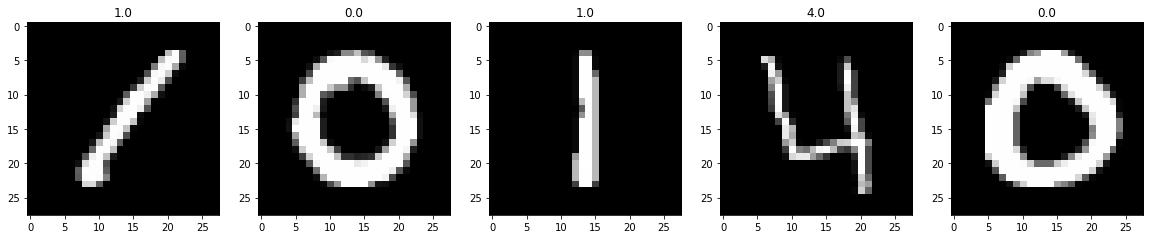

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

Сначала попробуем обойтись вообще без метода главных компонент. Для этого преобразуем исходные изображения, так чтобы из матрицы размером 28x28 они стали вектор-столбцом 784x1.

In [8]:
train_val_all_pc = train[:, 1:]

In [9]:
train_val_all_pc.shape

(42000, 784)

## Разбиваем выборку на обучение и валидацию

In [10]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_val_all_pc, test_size = 0.2,
    random_state = 1000)

In [11]:
x_train.shape

(33600, 784)

In [12]:
## Создаём дерево решений ...

In [13]:
tree = DecisionTreeClassifier()

In [14]:
tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [15]:
# ... и оцениваем точность классификации
model_pred = tree.predict(x_val)
report = classification_report(y_val, model_pred)
f1 = f1_score(y_val, model_pred, average = 'macro')
print(classification_report(y_val, model_pred))
print(f1)

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       787
         1.0       0.92      0.96      0.94       931
         2.0       0.84      0.83      0.83       880
         3.0       0.81      0.83      0.82       868
         4.0       0.85      0.86      0.86       822
         5.0       0.81      0.79      0.80       755
         6.0       0.90      0.88      0.89       832
         7.0       0.88      0.89      0.89       860
         8.0       0.83      0.79      0.81       814
         9.0       0.82      0.82      0.82       851

    accuracy                           0.86      8400
   macro avg       0.86      0.86      0.86      8400
weighted avg       0.86      0.86      0.86      8400

0.8573839829478314


Confusion matrix:
[[723   1  12   6   4  16  12   1   8   4]
 [  0 896   7   8   6   2   4   3   4   1]
 [ 11  18 729  31  12   9   7  26  22  15]
 [  8   7  29 720  10  37   4  15  22  16]
 [  3   9   9   5 711   6  10   8  11  50]
 [  8   9  17  41  14 596  19  12  20  19]
 [ 15   4  11   7  16  22 735   4  14   4]
 [  7   6  21  17  10   8   1 763   7  20]
 [  7  22  20  26  20  24  19   6 645  25]
 [  4   6  16  25  32  20   2  26  25 695]]


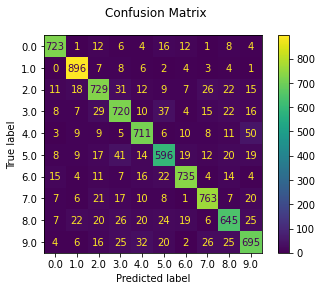

In [16]:
disp = metrics.plot_confusion_matrix(tree, x_val, y_val)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

In [17]:
X = x_train.astype(np.float32)

In [18]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [19]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

## Собственные числа

In [20]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

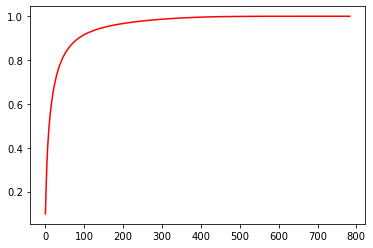

In [21]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, '-r')

In [22]:
for i in range(290, 310):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[290] 0.985
[291] 0.985
[292] 0.985
[293] 0.986
[294] 0.986
[295] 0.986
[296] 0.986
[297] 0.986
[298] 0.986
[299] 0.986
[300] 0.986
[301] 0.987
[302] 0.987
[303] 0.987
[304] 0.987
[305] 0.987
[306] 0.987
[307] 0.987
[308] 0.988
[309] 0.988


## Понижаем размерность

In [23]:
# При использовании 300 главных компонент накопленная сумма собственных значений превышает 0,98
# Попробуем установить количество компонент равным 300
n_comp = 300

In [24]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

In [25]:
Xrot_reduced.shape

(33600, 300)

In [26]:
# Теперь вычитаем среднее и понижаем размерность для валидационной выборки
x_val = x_val.astype(np.float32)
X_val = x_val - X_mean

In [27]:
X_val_rot_reduced = np.dot(X_val, U[:, :n_comp])

In [28]:
X_val_rot_reduced.shape

(8400, 300)

In [29]:
# Заново обучаем дерево решений ...

In [30]:
tree.fit(Xrot_reduced, y_train)

DecisionTreeClassifier()

In [31]:
# ... и оцениваем точность классификации
model_pred = tree.predict(X_val_rot_reduced)
report = classification_report(y_val, model_pred)
f1 = f1_score(y_val, model_pred, average = 'macro')
print(classification_report(y_val, model_pred))
print(f1)

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       787
         1.0       0.94      0.95      0.95       931
         2.0       0.80      0.78      0.79       880
         3.0       0.76      0.77      0.77       868
         4.0       0.77      0.77      0.77       822
         5.0       0.73      0.73      0.73       755
         6.0       0.86      0.85      0.85       832
         7.0       0.80      0.84      0.82       860
         8.0       0.76      0.73      0.74       814
         9.0       0.71      0.71      0.71       851

    accuracy                           0.80      8400
   macro avg       0.80      0.80      0.80      8400
weighted avg       0.80      0.80      0.80      8400

0.799299920510571


В целом, стало похуже, F1-score снизился с 86 % до 80 %. Теперь попробуем в цикле перебрать
возможные значения количества используемых главных компонент. Перебирать их с шагом 1 получится
очень долго, поэтому переберём с шагом 100

In [33]:
# Максимально возможное количество главных компонент
# не может превышать количество пикселей в исходном изображении
all_pc = (train_val_all_pc.shape[1] // 100) * 100
print(all_pc)

700


In [34]:
pca_num = []
pca_f1 = []

for i in tqdm(range(all_pc, 0, -100)):
    n_comp = i
    
    Xrot_reduced = np.dot(X, U[:, :n_comp])
    X_val_rot_reduced = np.dot(X_val, U[:, :n_comp])
    
    tree.fit(Xrot_reduced, y_train)
    
    model_pred = tree.predict(X_val_rot_reduced)
    f1 = f1_score(y_val, model_pred, average = 'macro')
    
    pca_num.append(n_comp)
    pca_f1.append(f1)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:59<00:00, 42.82s/it]


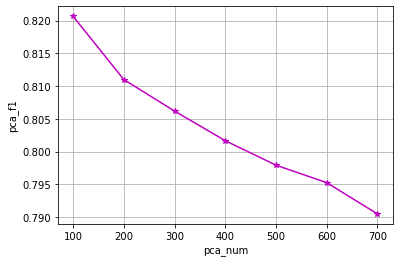

In [35]:
plt.plot(pca_num, pca_f1, 'm-*')
plt.xlabel('pca_num')
plt.ylabel('pca_f1')
plt.grid()

In [36]:
pca_f1

[0.7904825308535004,
 0.7952561170316387,
 0.7979235222113397,
 0.8016651474171941,
 0.8061864960715702,
 0.8110010368630064,
 0.8206662735343434]

Как ни странно, получилось, что с уменьшением количества используемых главных компонент
точность прогнозирования повышается. В предположении, что исследуемая функция гладкая,
проведём эксперимент для интервала (0, 100] с шагом 10

In [37]:
pca_num_10 = []
pca_f1_10 = []

for i in tqdm(range(100, 0, -10)):
    n_comp = i
    
    Xrot_reduced = np.dot(X, U[:, :n_comp])
    X_val_rot_reduced = np.dot(X_val, U[:, :n_comp])
    
    tree.fit(Xrot_reduced, y_train)
    
    model_pred = tree.predict(X_val_rot_reduced)
    f1 = f1_score(y_val, model_pred, average = 'macro')
    
    pca_num_10.append(n_comp)
    pca_f1_10.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.56s/it]


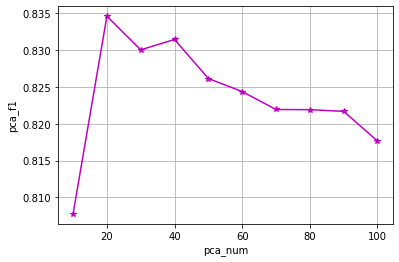

In [38]:
plt.plot(pca_num_10, pca_f1_10, 'm-*')
plt.xlabel('pca_num')
plt.ylabel('pca_f1')
plt.grid()

В интервале (0, 60] выполним эксперимент с шагом 1. Возможно, обнаружим что-нибудь интересное...

In [39]:
pca_num_1 = []
pca_f1_1 = []

for i in tqdm(range(60, 0, -1)):
    n_comp = i
    
    Xrot_reduced = np.dot(X, U[:, :n_comp])
    X_val_rot_reduced = np.dot(X_val, U[:, :n_comp])
    
    tree.fit(Xrot_reduced, y_train)
    
    model_pred = tree.predict(X_val_rot_reduced)
    f1 = f1_score(y_val, model_pred, average = 'macro')
    
    pca_num_1.append(n_comp)
    pca_f1_1.append(f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:53<00:00,  2.90s/it]


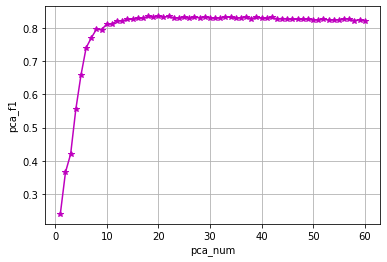

In [40]:
plt.plot(pca_num_1, pca_f1_1, 'm-*')
plt.xlabel('pca_num')
plt.ylabel('pca_f1')
plt.grid()

In [42]:
max(pca_f1_1)

0.8352185864481859

In [49]:
len(pca_num_1)

60

In [50]:
len(pca_f1_1)

60

In [53]:
pca_num_df = pd.DataFrame(pca_num_1, columns = ['num'])

In [55]:
pca_f1_df = pd.DataFrame(pca_f1_1, columns = ['f1'])

In [56]:
data = pca_num_df.join(pca_f1_df)

In [57]:
data.head()

,num,f1
0,60,0.821786
1,59,0.824992
2,58,0.822133
3,57,0.826422
4,56,0.828223


In [61]:
data.loc[data['f1'] == max(pca_f1_1)]

,num,f1
40,20,0.835219


Наибольшее достигаемое значение F1-score составляет 83,5 % при количестве главных компонент, равном 20.
Попробуем выполнить преобразование с количеством главных компонент, равным 20, и визуализировать цифры

In [63]:
n_comp = 20
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])
# восстанавливаем изображение после понижения размерности
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

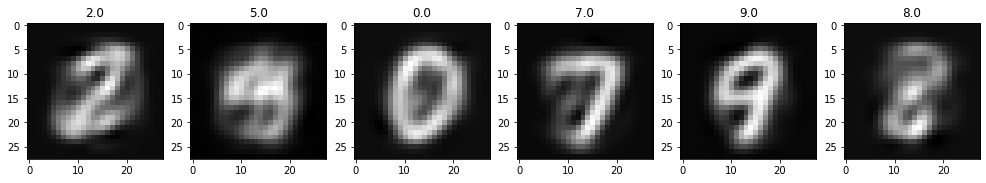

In [65]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y_train[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray');

Цифры угадываются с трудом, но для распознавания этого оказывается достаточно.
Таким образом, получаем следующие значения:
    * для всех данных F1-Score составляет 85,7 %,
    * для 20 главных компонент F1-Score составляет 83,5 %.